In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats

# import modules
import math
import time
import itertools
import os
import sys
import warnings
from datetime import datetime, timedelta, date

# import data processing and pipelines
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pmdarima import auto_arima
from scipy.stats import norm

# import custom transformer
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
from custom_modules.custom_transformers import TargetTransformer, TimeSeriesTransformer

In [2]:
# setting options
pd.options.display.max_columns = None
%matplotlib inline
sns.set(style='darkgrid')
random_seed = 42

In [13]:
# load bricks data
bricks = pd.read_csv('bricks_df.csv', sep=',', decimal='.', encoding='unicode_escape', index_col=[0])
# strip string from name column
bricks['name'] = bricks.name.str.replace('Smartbrick ', '')
# convert datetime columns to date
bricks[['created_date', 'updated_date']] = bricks[['created_date', 'updated_date']].apply(lambda x: pd.to_datetime(x, errors='coerce').dt.date)
# drop subject type id
bricks.drop('subject_type_id', axis=1, inplace=True)

# load custom metadata
meta = pd.read_csv('bricks_metadata.csv', sep=';', decimal='.', encoding='unicode_escape', converters = {'name': str})
# convert to datetime
meta['Datum plaatsing'] = pd.to_datetime(meta['Datum plaatsing'], errors='coerce')

# merge bricks with metadata
bricks = bricks.merge(meta, on='name', how='left')

# read measurements from file
measurements = pd.read_csv('measurements_df.csv', sep=',', decimal='.', encoding='unicode_escape')

# combine bricks with measurements
data = measurements.merge(bricks, on='id', how='left')

data.head()

,id,date,battery,humidity,rsrp,temperature,x,y,name,created_date,updated_date,subject_type_name,SmartBrick Versie,Datum plaatsing,Aantal bricks op deze locatie,Batch,Clustercode,Locatie,huisnummer,hoog/laag geplaatst?,Handmatig Gemeten Scheefstand
0,025d0d1c-006f-4fd9-9bc4-4693c3037e58,1644566661886,3.607,72.8,-101.0,11.9,-0.738525,-10.931396,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9
1,025d0d1c-006f-4fd9-9bc4-4693c3037e58,1644588261510,3.564,70.8,-86.0,13.9,-3.308105,-12.628174,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9
2,025d0d1c-006f-4fd9-9bc4-4693c3037e58,1644609860819,3.569,69.1,-104.0,14.5,-3.222656,-11.450195,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9
3,025d0d1c-006f-4fd9-9bc4-4693c3037e58,1644631460447,3.566,67.8,-100.0,15.0,-3.118896,-11.206055,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9
4,025d0d1c-006f-4fd9-9bc4-4693c3037e58,1644653060463,3.606,66.5,-99.0,14.6,-3.100586,-11.163330,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9


In [14]:
# initial data processing
def process_data(data):
    data['date'] = pd.to_datetime(data['date'], unit='ms').dt.round(freq='S')
    # only data after installation is valid
    data = data.loc[data['date'].dt.date > data['Datum plaatsing']]
    # convert to categorical columns
    data = data.astype({'Aantal bricks op deze locatie': 'category', 'Batch': 'category'})
    # filtering out measurements sent for proefbelasting bricks
    data = data.loc[data['Clustercode'] != 'Overamstel']
    # setting reference to 0 based on initial measurements
    data[['x', 'y']] = data.sort_values('date', ascending=True).groupby('id')[['x', 'y']].apply(lambda x: x-x[0:10].mean())
    
    return data.reset_index(drop=True)

data = process_data(data)
data.head()

,id,date,battery,humidity,rsrp,temperature,x,y,name,created_date,updated_date,subject_type_name,SmartBrick Versie,Datum plaatsing,Aantal bricks op deze locatie,Batch,Clustercode,Locatie,huisnummer,hoog/laag geplaatst?,Handmatig Gemeten Scheefstand
0,025d0d1c-006f-4fd9-9bc4-4693c3037e58,2022-02-16 02:04:17,3.564,73.5,-99.0,8.2,0.004883,-0.010986,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9
1,025d0d1c-006f-4fd9-9bc4-4693c3037e58,2022-02-16 08:04:16,3.600,74.9,-98.0,9.7,-0.007324,-0.010986,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9
2,025d0d1c-006f-4fd9-9bc4-4693c3037e58,2022-02-16 14:04:18,3.566,75.8,-100.0,10.9,-0.007324,-0.010986,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9
3,025d0d1c-006f-4fd9-9bc4-4693c3037e58,2022-02-16 20:04:15,3.566,77.8,-98.0,10.8,-0.001221,-0.004883,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9
4,025d0d1c-006f-4fd9-9bc4-4693c3037e58,2022-02-17 02:04:15,3.566,80.3,-96.0,8.8,-0.001221,0.001221,148050,2022-02-11,NaT,Smartbrick Interay,Inter V1.0,2022-02-15,7.0,4.0,BDG0201,Bildijkkade,14,NaN,89.4 - 89.9


In [124]:
# split into training and testing sets, storing away safely
train, test = train_test_split(data, test_size=0.2, random_state=random_seed, stratify=data['name'])
print(f'Rows in training set: {len(train)}, and in test set: {len(test)}.')

Rows in training set: 48442, and in test set: 12111.


In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48442 entries, 31959 to 52876
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             48442 non-null  object        
 1   date                           48442 non-null  datetime64[ns]
 2   battery                        48442 non-null  float64       
 3   humidity                       48442 non-null  float64       
 4   rsrp                           48442 non-null  float64       
 5   temperature                    48442 non-null  float64       
 6   x                              48442 non-null  float64       
 7   y                              48442 non-null  float64       
 8   name                           48442 non-null  object        
 9   created_date                   48442 non-null  object        
 10  updated_date                   1141 non-null   object        
 11  subject_typ

## Explorative Data Analysis

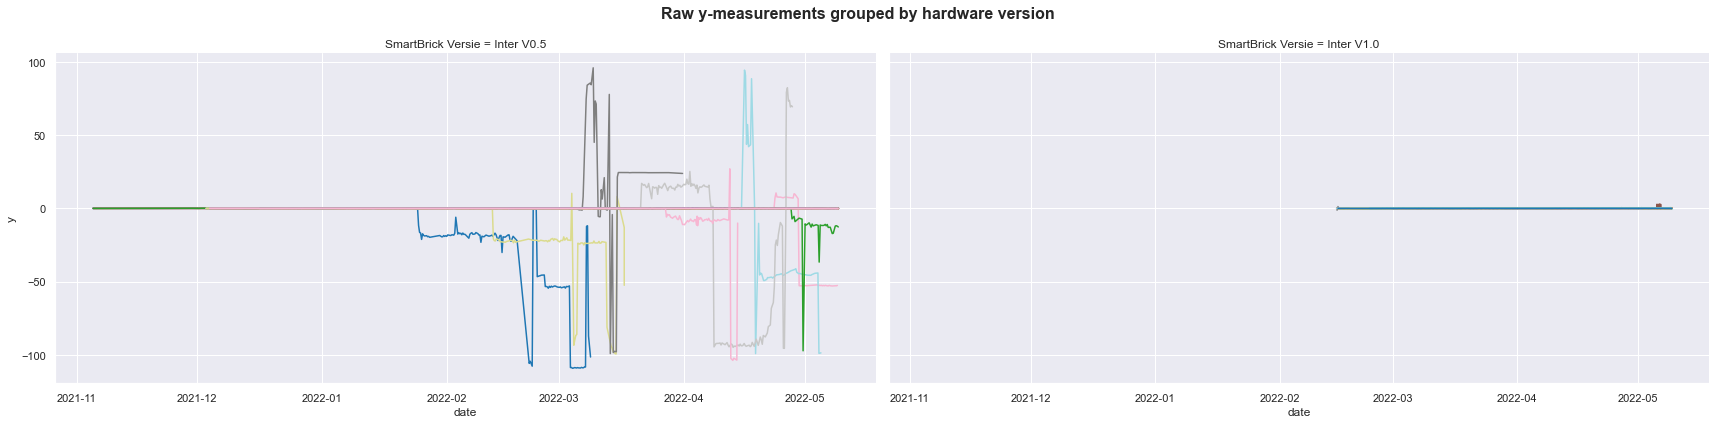

In [126]:
ax = sns.relplot(
    data=train, x='date', y='y',
    col='SmartBrick Versie',
    hue='name', palette='tab20', legend=False,
    kind='line', height=6, aspect=2
)
ax.fig.suptitle('Raw y-measurements grouped by hardware version', fontsize=16, fontweight='bold')
ax.fig.tight_layout()
plt.show()

In [152]:
def transformer_pipeline(data):
    # initialize transformer
    transformer = TargetTransformer(IQR=True, q=[.1, .9])
    # transform data based on outliers in y measurements over entire distribution
    tf_data = transformer.fit_transform(data, cols=['x', 'y', 'temperature'])
    print(f"Before transform: {len(data)} rows --> After: {len(tf_data)} rows")
    '''
    # initialize a new transformer
    transformer = TargetTransformer(IQR=False, trim_spikes=True, q=[.1, .9], d=1.5, period=5)
    # apply new transformer to each brick
    tf_data2 = tf_data.sort_values('date', ascending=True).groupby('id')\
        .apply(lambda x: transformer.fit_transform(x, cols=['x', 'y'])).reset_index(drop=True)
    print(f"Before transform: {len(tf_data)} rows --> After: {len(tf_data2)} rows")
    '''
    # standardizing numerical columns
    scaler = StandardScaler()
    num_cols = ['x', 'y', 'temperature']
    tf_data = pd.concat([tf_data, pd.DataFrame(scaler.fit_transform(tf_data[num_cols].to_numpy()), columns=[f'{x}_scaled' for x in num_cols])], axis=1)

    # resampling to 1hr intervals
    tf_data = tf_data.groupby('name').resample(rule='1H', on='date').mean().dropna().reset_index()
    tf_data = tf_data.merge(data[['name'] + [col for col in data.columns if col not in tf_data.columns]], on='name', how='left')

    return tf_data

# transforming training set
tf_train = transformer_pipeline(train)

# plotting transformed training data
ax = sns.relplot(
    data=tf_train, x='date', y='y',
    col='SmartBrick Versie',
    hue='name', palette='tab20', legend=False,
    kind='line', height=6, aspect=2
)
ax.fig.suptitle('Raw y-measurements grouped by hardware version', fontsize=16, fontweight='bold')
ax.fig.tight_layout()
plt.show()

Before transform: 48442 rows --> After: 47251 rows


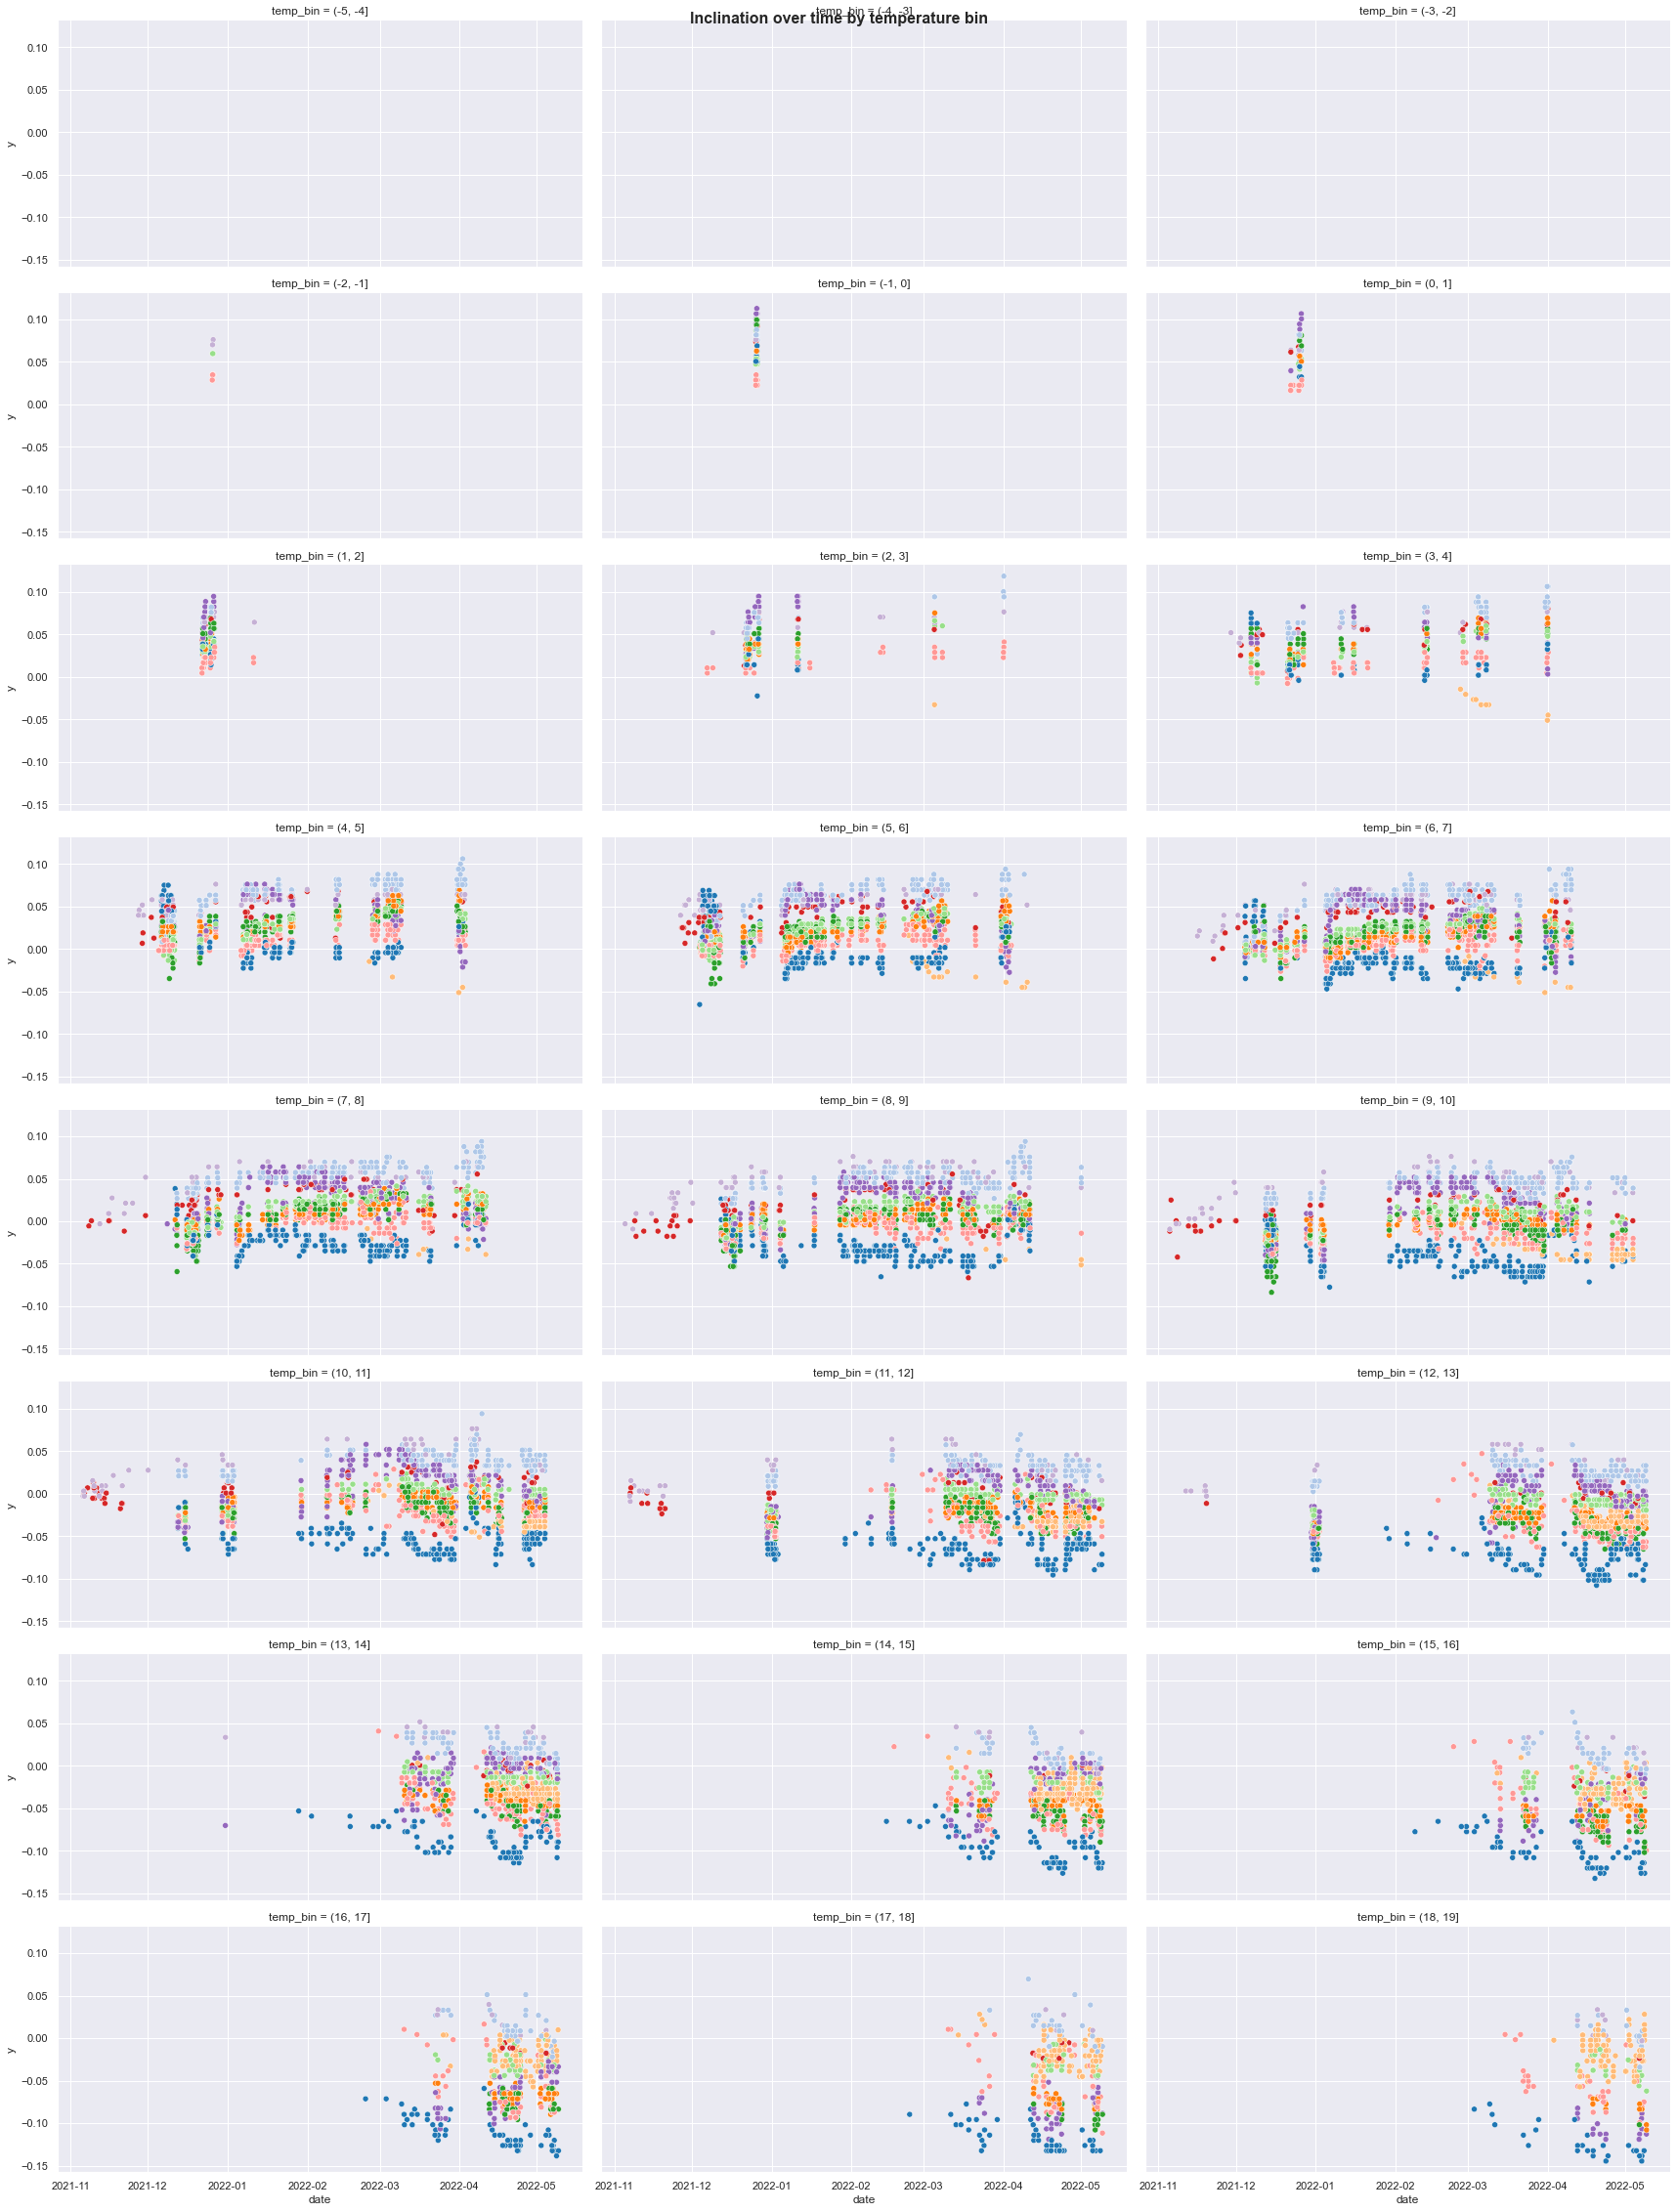

In [128]:
# creating temperature bins
tf_train['temp_bin'] = pd.cut(tf_train['temperature'], bins=range(-5, 20, 1))

# checking distribution of categoricals
top10 = tf_train.groupby(['name', 'SmartBrick Versie']).agg({'id': ['count']}).sort_values(('id', 'count'), ascending=False).head(10).index.get_level_values(0).tolist()

# plotting transformed training data
ax = sns.relplot(
    data=tf_train.loc[tf_train['name'].isin(top10)], x='date', y='y',
    col='temp_bin', col_wrap=3,
    hue='name', palette='tab20', legend=False,
    kind='scatter', height=4, aspect=2
)
ax.fig.suptitle('Inclination over time by temperature bin', fontsize=16, fontweight='bold')
ax.fig.tight_layout()
plt.show()

In [ ]:
tf_train2.loc[filter].groupby(['name', 'Locatie']).resample(rule='1H', on='date').mean().dropna().reset_index()

In [137]:
tf_train.loc[tf_train['name'].isin(top10)].groupby('name').resample(rule='1H', on='date').mean().dropna().reset_index()

,name,date,battery,humidity,rsrp,temperature,x,y,x_scaled,y_scaled,temperature_scaled
0,141432,2021-11-05 08:00:00,3.70200,63.700,-72.00,9.100,-0.032959,-0.011597,0.925462,-0.439243,0.634985
1,141432,2021-11-05 20:00:00,3.67700,63.800,-72.00,10.000,-0.002441,0.025024,-0.781080,0.989440,-0.256134
2,141432,2021-11-06 08:00:00,3.69400,65.200,-68.00,10.400,0.003662,0.000610,2.155759,2.706608,1.526105
3,141432,2021-11-07 02:00:00,3.68100,66.000,-69.00,11.300,0.015869,0.000610,0.350000,-1.771764,0.448472
4,141432,2021-11-07 08:00:00,3.70200,66.400,-69.00,11.100,0.009766,0.006714,0.806401,0.000352,-0.276858
...,...,...,...,...,...,...,...,...,...,...,...
17547,148078,2022-05-09 03:00:00,3.56550,66.075,-86.25,12.025,-0.006409,-0.032959,0.925462,-0.507929,0.184245
17548,148078,2022-05-09 04:00:00,3.56575,66.375,-87.00,12.075,-0.009460,-0.032959,0.354961,-0.140456,-0.370115
17549,148078,2022-05-09 05:00:00,3.56680,64.920,-86.60,15.140,-0.001221,-0.004883,0.461123,0.148715,-0.135937
17550,148078,2022-05-09 06:00:00,3.56575,57.950,-87.50,24.875,-0.027771,-0.017700,0.265665,0.793683,-0.680971


In [136]:
tf_train.loc[tf_train['name'].isin(top10)].melt(id_vars=['name', 'date'], value_vars=['y_scaled', 'temperature_scaled']).resample(rule='1H', on='date').mean()#.dropna().reset_index()

,value
date,
2021-11-05 02:00:00,0.672444
2021-11-05 03:00:00,NaN
2021-11-05 04:00:00,NaN
2021-11-05 05:00:00,NaN
2021-11-05 06:00:00,NaN
...,...
2022-05-09 06:00:00,-0.007323
2022-05-09 07:00:00,-0.004032
2022-05-09 08:00:00,0.025591


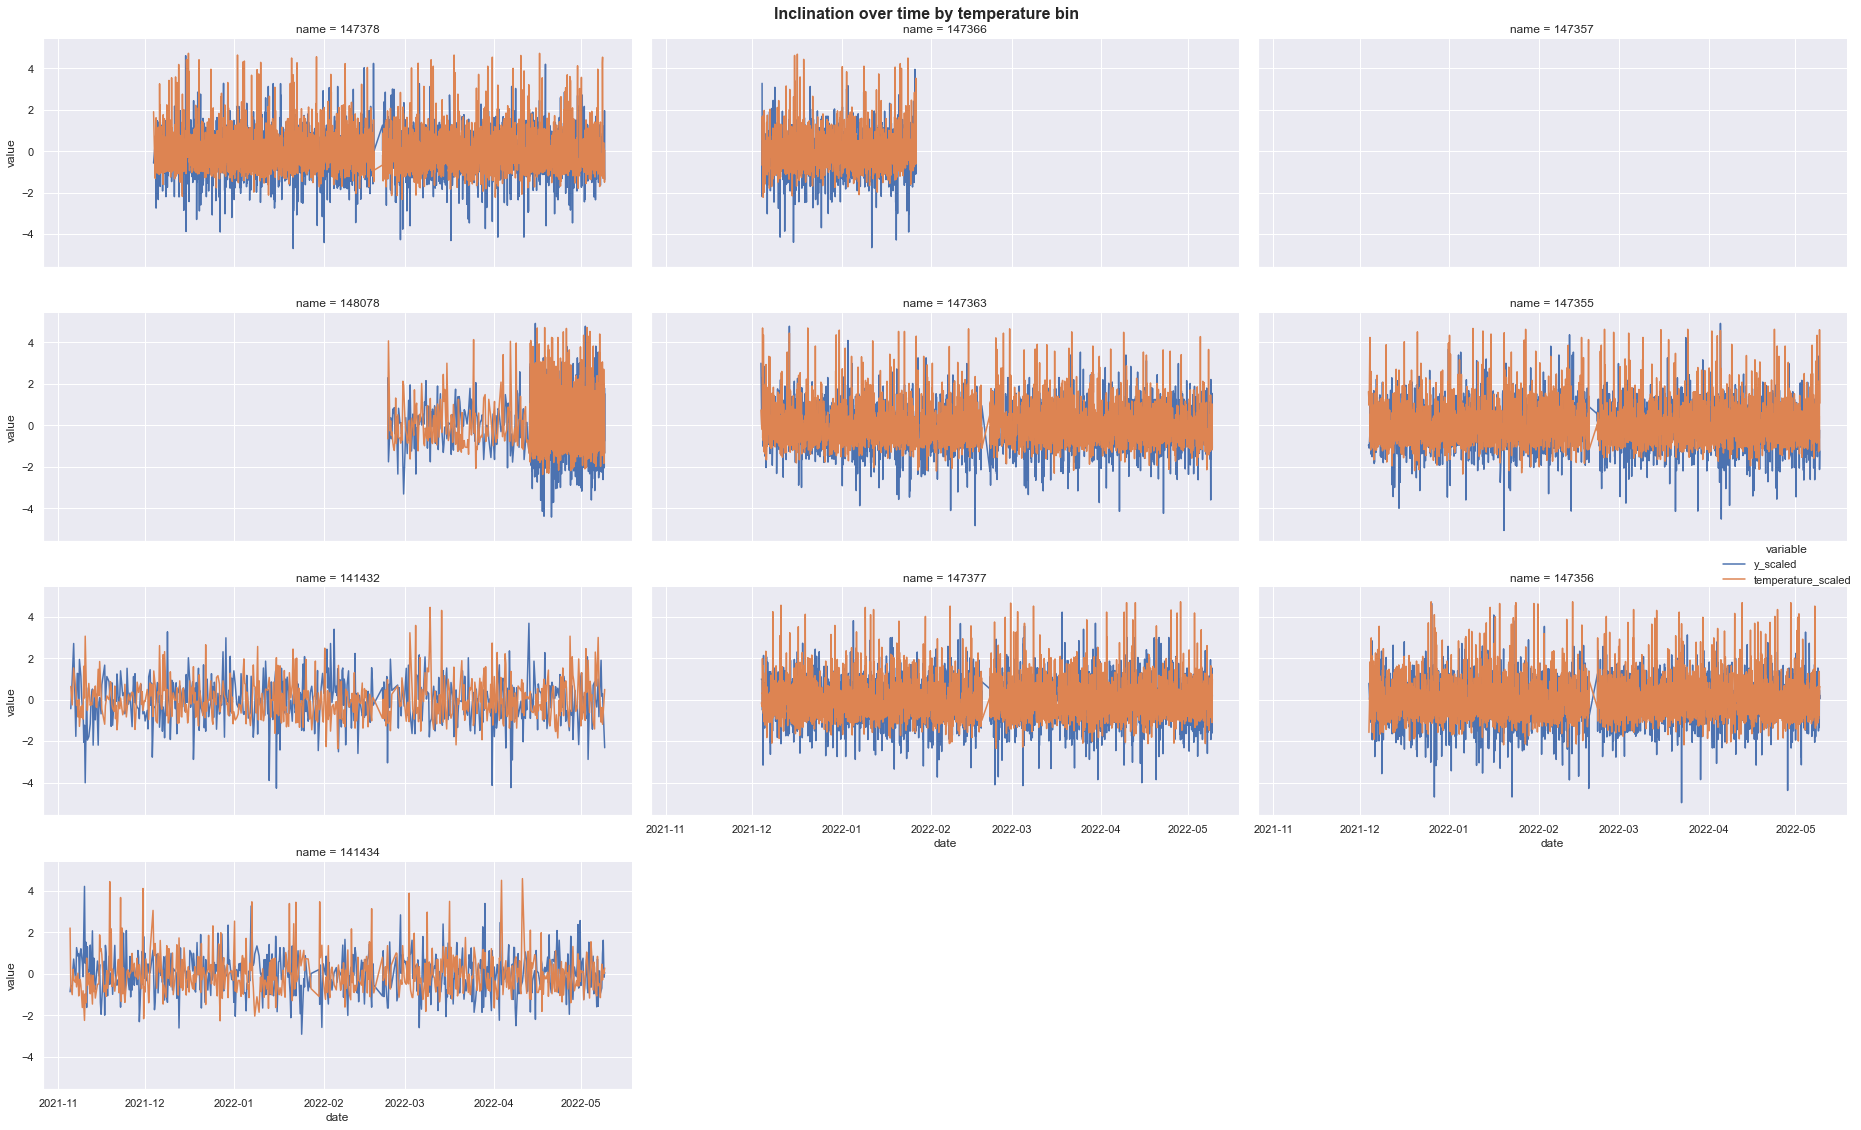

In [133]:
# plotting transformed training data
ax = sns.relplot(
    data=tf_train.loc[tf_train['name'].isin(top10)].melt(id_vars=['name', 'date'], value_vars=['y_scaled', 'temperature_scaled']), x='date', y='value',
    col='name', col_wrap=3,
    hue='variable',# palette='tab20',
    kind='line', height=4, aspect=2
)
ax.fig.suptitle('Inclination over time by temperature bin', fontsize=16, fontweight='bold')
ax.fig.tight_layout()
plt.show()